### Setup

I load the required libraries and configure some settings for plots.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

Next, we load the data from the Excel file.

In [4]:
df = pd.read_excel('Online Retail.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'], 
                   infer_datetime_format=True)

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df[pd.isnull(df['CustomerID'])].count()

InvoiceNo      135080
StockCode      135080
Description    133626
Quantity       135080
InvoiceDate    135080
UnitPrice      135080
CustomerID          0
Country        135080
dtype: int64

In [9]:
df.dropna(subset=['CustomerID'], inplace=True)

The dataset contains missing values in the `CustomerID` column. That is why we drop such rows from the dataset.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


### EDA

I inspect the distribution of the numeric variables - quantity and unit price.

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [14]:
np.sum(df.Quantity < 0)

8905

There are around `9k` purchases with negative quantity, most likely returns. I will remove them from the dataset.

In [15]:
df = df[df['Quantity'] > 0]

I can calculate an aggregate metric indicating how many orders were placed by each customer and plot the distribution.

In [16]:
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['CustomerID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

65.57% of customers ordered more than once.


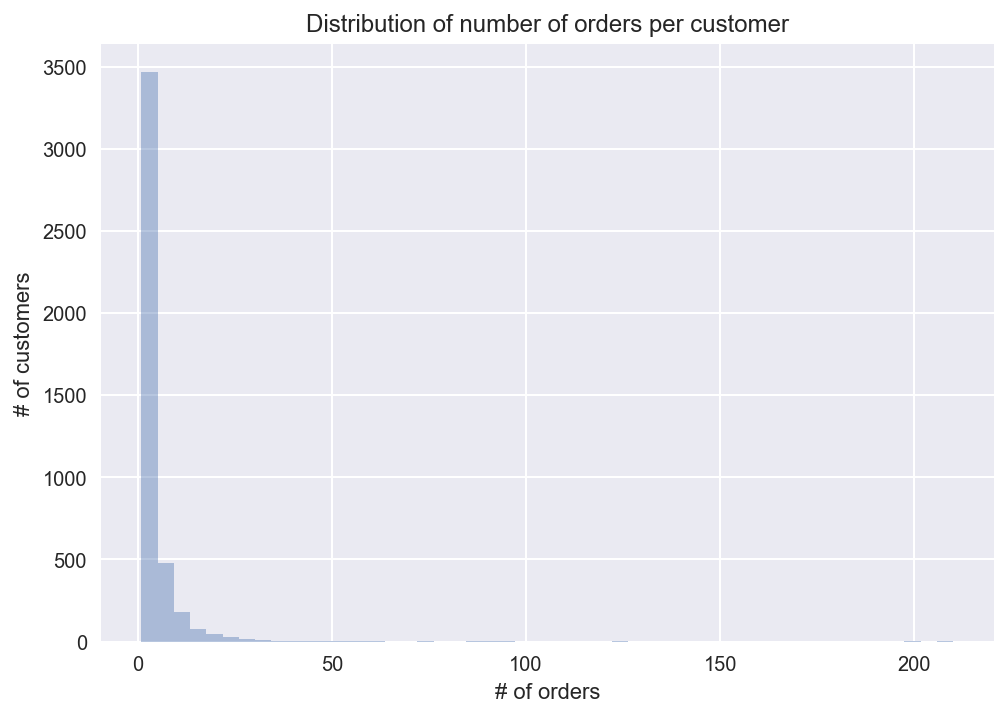

In [19]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

### Cohort analysis

In this part, I carry out the cohort analysis.

In [21]:
# keep only the relevant data
df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [22]:
# create two variables: month of order and cohort
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

In [23]:
df

,CustomerID,InvoiceNo,InvoiceDate,order_month,cohort
0,17850,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047,536369,2010-12-01 08:35:00,2010-12,2010-12
...,...,...,...,...,...
541865,13777,581583,2011-12-09 12:23:00,2011-12,2010-12
541867,13777,581584,2011-12-09 12:25:00,2011-12,2010-12
541869,15804,581585,2011-12-09 12:31:00,2011-12,2011-05
541890,13113,581586,2011-12-09 12:49:00,2011-12,2010-12


In [24]:
# add an indicator for periods (months since first purchase)
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [27]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4
...,...,...,...,...
86,2011-10,2011-11,86,1
87,2011-10,2011-12,41,2
88,2011-11,2011-11,324,0
89,2011-11,2011-12,36,1


In [28]:
# pivot the data into a form of the matrix
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [29]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# divide by the cohort size (month 0) to obtain retention as %
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [32]:
cohort_size

cohort
2010-12    885.0
2011-01    417.0
2011-02    380.0
2011-03    452.0
2011-04    300.0
2011-05    284.0
2011-06    242.0
2011-07    188.0
2011-08    169.0
2011-09    299.0
2011-10    358.0
2011-11    324.0
2011-12     41.0
Freq: M, Name: 0, dtype: float64

In [33]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


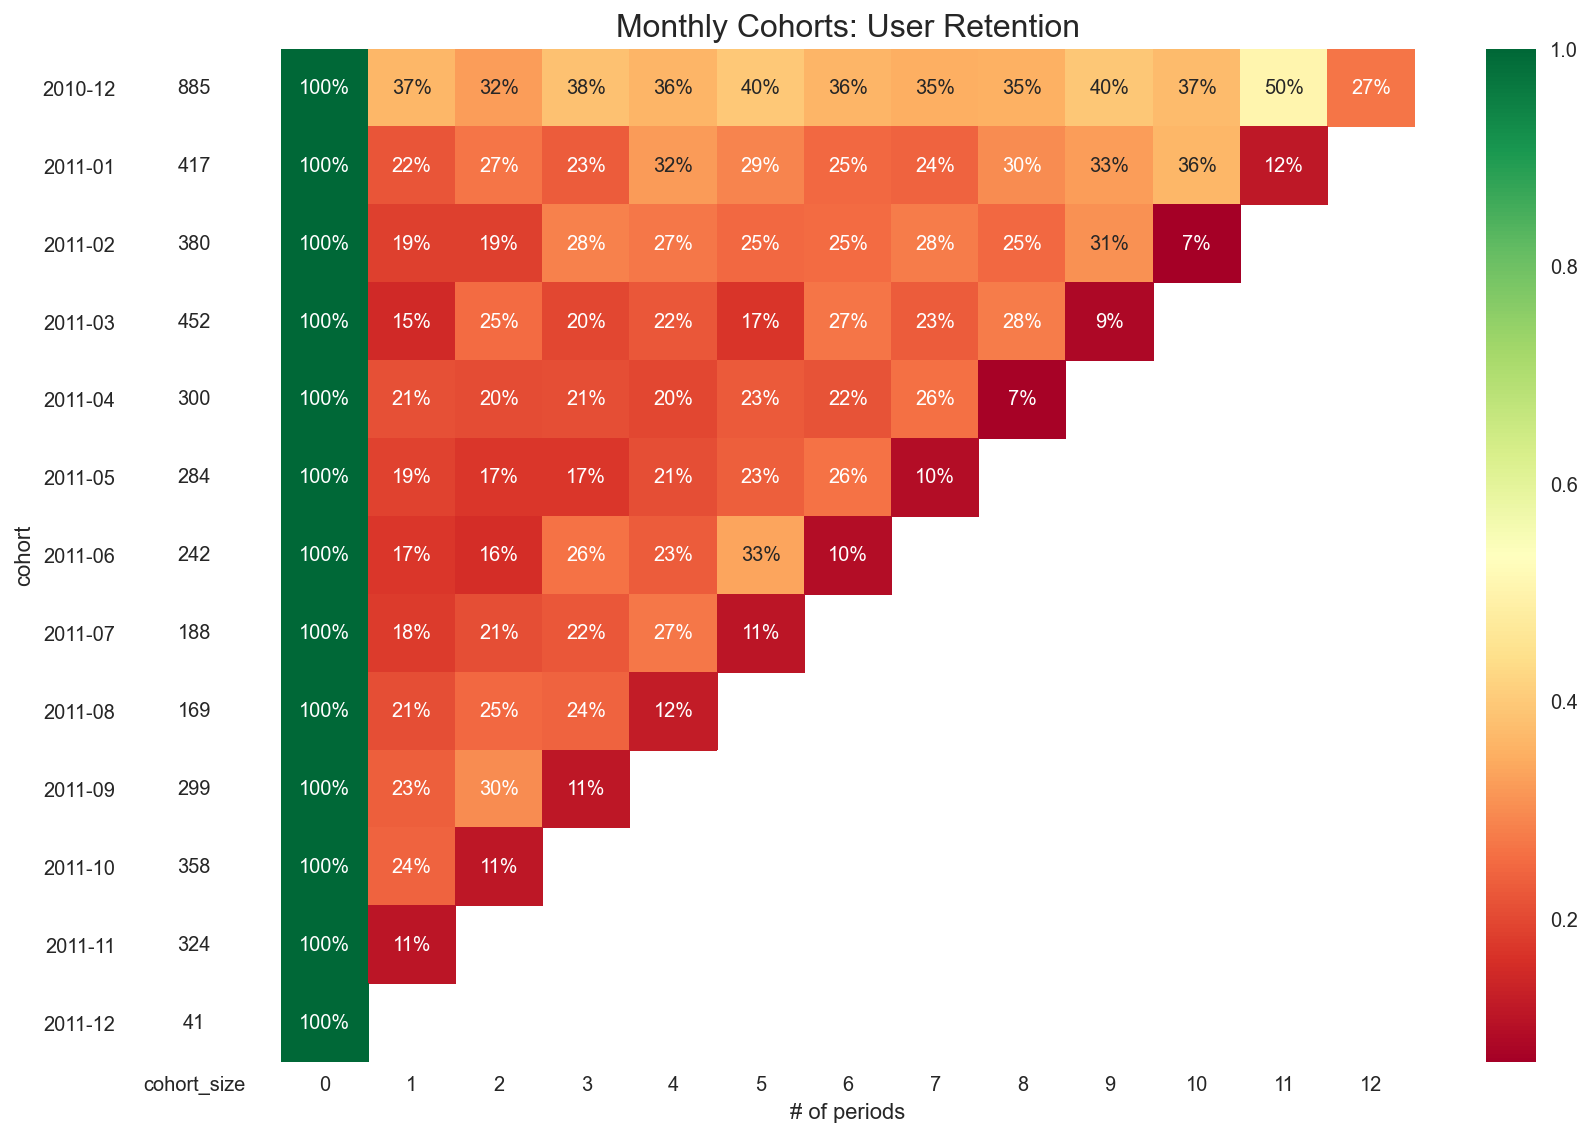

In [34]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()